In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import nn, optim
from torchvision import transforms as T
from torchvision.utils import make_grid, save_image

from gan import models, kl_cycle_gan_loss_step, build_cycle_gan_trainer

from utils.checkpoints import load_checkpoint, save_checkpoint
from utils.display import display_images
from utils.benchmark import train
from utils.datasets import DomainDataset
from __datasets__ import ITSDataset, DenseHazeCVPR2019Dataset

In [3]:
config = models.CycleGanConfig(
    "haze2clear",
    writer=True,
    p=0,
    sampling_layers=2,
    lr=2e-4,
    blocks=(64, 128, 256, 512),
    residuals=5
)

In [4]:
ds_train = DomainDataset(
    ITSDataset(
        DIR="../../pytorch/datasets/its",
        SET="hazy",
        download=True,
        sub_sample=0.1,
        image_transform=T.Compose([
            T.Resize((128, 128)),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            lambda x: x.to(config.device),
        ])),
    ITSDataset(
        DIR="../../pytorch/datasets/its",
        SET="clear",
        download=True,
        sub_sample=0.5,
        image_transform=T.Compose([
            T.Resize((128, 128)),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            lambda x: x.to(config.device),
        ])),
)
ds_val = DomainDataset(
    DenseHazeCVPR2019Dataset(
        DIR="../../pytorch/datasets/dense-haze-cvpr-2019",
        SET="hazy",
        download=True,
        sub_sample=1,
        image_transform=T.Compose([
            T.Resize((256, 256)),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            lambda x: x.to(config.device),
        ])),
    DenseHazeCVPR2019Dataset(
        DIR="../../pytorch/datasets/dense-haze-cvpr-2019",
        SET="GT",
        download=True,
        sub_sample=1,
        image_transform=T.Compose([
            T.Resize((256, 256)),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            lambda x: x.to(config.device),
        ])),
)
len(ds_train), len(ds_val)

(1399, 55)

In [5]:
generatorA, generatorB, discriminatorA, discriminatorB = models.build_CycleGan(config)
optimizerG = optim.Adam([*generatorA.parameters(), *generatorB.parameters()], betas=config.betas)
optimizerD = optim.Adam([*discriminatorA.parameters(), *discriminatorB.parameters()], betas=config.betas)

In [6]:
if input("Load Model[y|n]?> ").lower() == "y":
    others = load_checkpoint(
        input("path?> "),
        models={
            "generatorA": generatorA,
            "generatorB": generatorB,
            "discriminatorA": discriminatorA,
            "discriminatorB": discriminatorB,
        },
        optimizers={
            "generator": optimizerG,
            "discriminator": optimizerD,
        }
    )
    step_offset = others["step"]
else:
    step_offset = 0
print("step_offset:", step_offset)

step_offset: 0


In [7]:
def data_extractor(DATA):
    return DATA["domain0"]["image"], DATA["domain1"]["image"]


fixed_inp = data_extractor(ds_val[:9])
trainer = build_cycle_gan_trainer(
    generatorA, generatorB, discriminatorA, discriminatorB,
    optimizerG, optimizerD,
    kl_cycle_gan_loss_step,
    data_extractor,
    writer=config.writer, writer_period=500, fixed_inp=fixed_inp,
    save_path=config.checkpoint_path, save_period=1000,
    perceptual_loss=True,
    device=config.device,
)

In [8]:
generatorA = generatorA.train()
generatorB = generatorB.train()
discriminatorA = discriminatorA.train()
discriminatorB = discriminatorB.train()
step_offset = train(
    trainer, ds_train,
    ne=1, bs=8,
    step_offset=step_offset,
)
step_offset

Epoch: 0/1 | Batch 0/175|          |  0% [00:00<?, ?it/s ]

/Users/amith.m/PycharmProjects/GANExp/venv/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


175

In [ ]:
if input("Save Model[y|n]?> ").lower() == "y":
    save_checkpoint(
        f"{config.name}-model.pth",
        models={
        },
    )

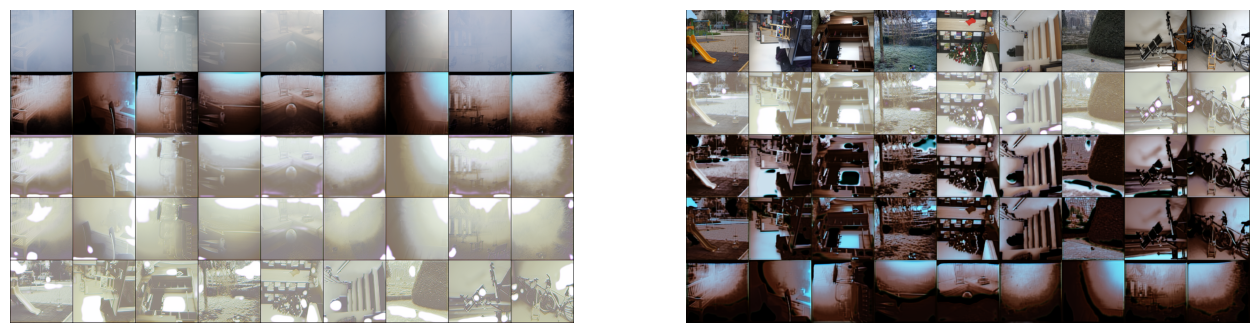

CPU times: user 1.38 s, sys: 1.32 s, total: 2.71 s
Wall time: 8.13 s


In [9]:
%%time

generatorA = generatorA.eval()
generatorB = generatorB.eval()
discriminatorA = discriminatorA.eval()
discriminatorB = discriminatorB.eval()
with torch.inference_mode():
    realA, realB = fixed_inp
    fakeA, fakeB = generatorA(realB), generatorB(realA)
    backA, backB = generatorB(fakeA), generatorA(fakeB)
    sameA, sameB = generatorA(realA), generatorB(realB)
    doubleA, doubleB = generatorA(fakeA), generatorB(fakeB)
    gridA = make_grid(torch.cat([realA, fakeB, backB, sameA, doubleA], dim=0), nrow=len(realA), normalize=True)
    gridB = make_grid(torch.cat([realB, fakeA, backA, sameB, doubleB], dim=0), nrow=len(realB), normalize=True)
display_images(torch.stack([gridA, gridB]).cpu().permute(0, 2, 3, 1))

In [10]:
save_image(gridA, "gridA.png")
save_image(gridB, "gridB.png")